 ## Packages

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import lightning as pl
from simplelogger import SimpleLogger
import sys

In [3]:
print(f"Python version -> {sys.version}")  # 3.12.3
print(f"torch version -> {torch.__version__}")  # 2.8.0+cu128
print(f"lightning version -> {pl.__version__}")  # 2.5.5

Python version -> 3.13.3 (tags/v3.13.3:6280bb5, Apr  8 2025, 14:47:33) [MSC v.1943 64 bit (AMD64)]
torch version -> 2.9.1+cpu
lightning version -> 2.5.6


 ## Importing Data

In [4]:
transform = transforms.Compose([transforms.ToTensor()])  # converts [0,255] → [0,1]

train_dataset = datasets.MNIST(
    root="../data", train=True, download=True, transform=transform
)
test_dataset = datasets.MNIST(
    root="../data", train=False, download=True, transform=transform
)

x_train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
x_test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples : {len(test_dataset)}")

Train samples: 60000
Test samples : 10000


 ## Data Normalization

In [5]:
# Note: torchvision.transforms.ToTensor() already normalizes to [0,1]
example_data, example_target = next(iter(x_train_loader))
print(f"Example batch shape: {example_data.shape}")

Example batch shape: torch.Size([512, 1, 28, 28])


 ### Some examples

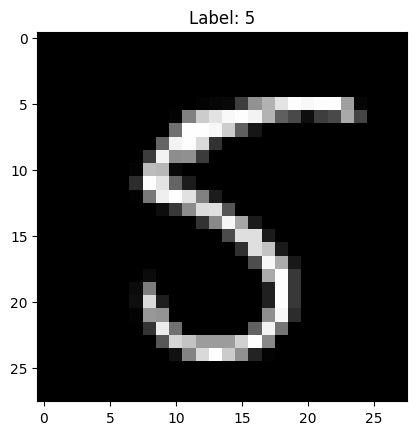

In [6]:
plt.imshow(example_data[8][0], cmap="gray")
plt.title(f"Label: {example_target[8].item()}")
plt.show()

 ## Building model

In [7]:
hidden1 = 16
hidden2 = 16


class MLPModel(pl.LightningModule):
    def __init__(self, lr=1e-3):
        super(MLPModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.criterion = torch.nn.CrossEntropyLoss()
        self.running_losses = {"train": [], "val": []}
        self.log_loss = {"train": [], "val": []}
        self.lr = lr

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def compute_loss(self, batch, batch_idx, name):
        image, label = batch
        label_prediction = self(image)
        loss = self.criterion(label_prediction, label)
        accuracy = (label_prediction.argmax(1) == label).float().mean()
        self.log(f"{name}_loss", loss, on_epoch=True, on_step=False)
        self.log(f"{name}_acc", accuracy, on_epoch=True, on_step=False)

        return loss

    def training_step(self, batch, batch_idx):
        return self.compute_loss(batch, batch_idx, "train")

    def validation_step(self, batch, batch_idx):
        return self.compute_loss(batch, batch_idx, "val")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return [optimizer]


model = MLPModel()
print(model)

MLPModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=10, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
  (criterion): CrossEntropyLoss()
)


 ## Train the model

In [8]:
trainer = pl.Trainer(
    max_epochs=10,
    logger=SimpleLogger(),
    enable_checkpointing=False,
    check_val_every_n_epoch=1,
)  # logger=False, enable_checkpointing=False to avoid polluting your workspace with lightning_logs and checkpoints

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [9]:
trainer.fit(model, x_train_loader, x_test_loader)


  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | flatten   | Flatten          | 0      | train
1 | fc1       | Linear           | 12.6 K | train
2 | fc2       | Linear           | 272    | train
3 | fc3       | Linear           | 170    | train
4 | relu      | ReLU             | 0      | train
5 | softmax   | Softmax          | 0      | train
6 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
13.0 K    Trainable params
0         Non-trainable params
13.0 K    Total params
0.052     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


c:\Users\victo\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
c:\Users\victo\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 118/118 [00:07<00:00, 15.84it/s, v_num=Data]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 118/118 [00:07<00:00, 15.84it/s, v_num=Data]


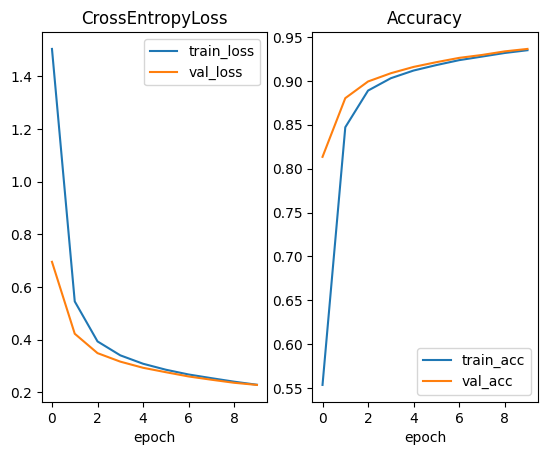

In [10]:
train_loss = trainer.logger.metrics["train_loss"]
val_loss = trainer.logger.metrics["val_loss"]
plt.subplot(1, 2, 1)
plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.xlabel("epoch")
plt.title("CrossEntropyLoss")

plt.legend()
train_acc = trainer.logger.metrics["train_acc"]
val_acc = trainer.logger.metrics["val_acc"]
plt.subplot(1, 2, 2)
plt.plot(train_acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.xlabel("epoch")
plt.title("Accuracy")
plt.legend()

 ## Evaluation of the model

In [11]:
model.eval()
correct, total = 0, 0
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in x_test_loader:
        images, labels = images, labels
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f"Test accuracy : {test_accuracy:.4f}")

Test accuracy : 0.9364


 ## Plot history

 ## Performance Analysis

In [12]:
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[ 966    0    2    1    0    3    6    1    1    0]
 [   0 1110    5    1    0    1    3    2   13    0]
 [  10    4  940   19    9    4   11    8   25    2]
 [   2    0   15  937    2   23    0   11   16    4]
 [   1    1    6    0  922    0    9    3    9   31]
 [  10    1    9   37    3  787    9    5   23    8]
 [   9    3    6    1   10   15  911    1    2    0]
 [   2    9   10   11    8    0    0  970    4   14]
 [   6   11    5   16   10   17    6   10  884    9]
 [  10    6    0   10   21    5    1   11    8  937]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       980
           1       0.97      0.98      0.97      1135
           2       0.94      0.91      0.93      1032
           3       0.91      0.93      0.92      1010
           4       0.94      0.94      0.94       982
           5       0.92      0.88      0.90       892
           6       0.95      0.95      0.95       958
           7       0.95      0.94   

In [13]:
errors = [i for i in range(len(y_true)) if y_true[i] != y_pred[i]]
print("Number of errors:", len(errors))

Number of errors: 636


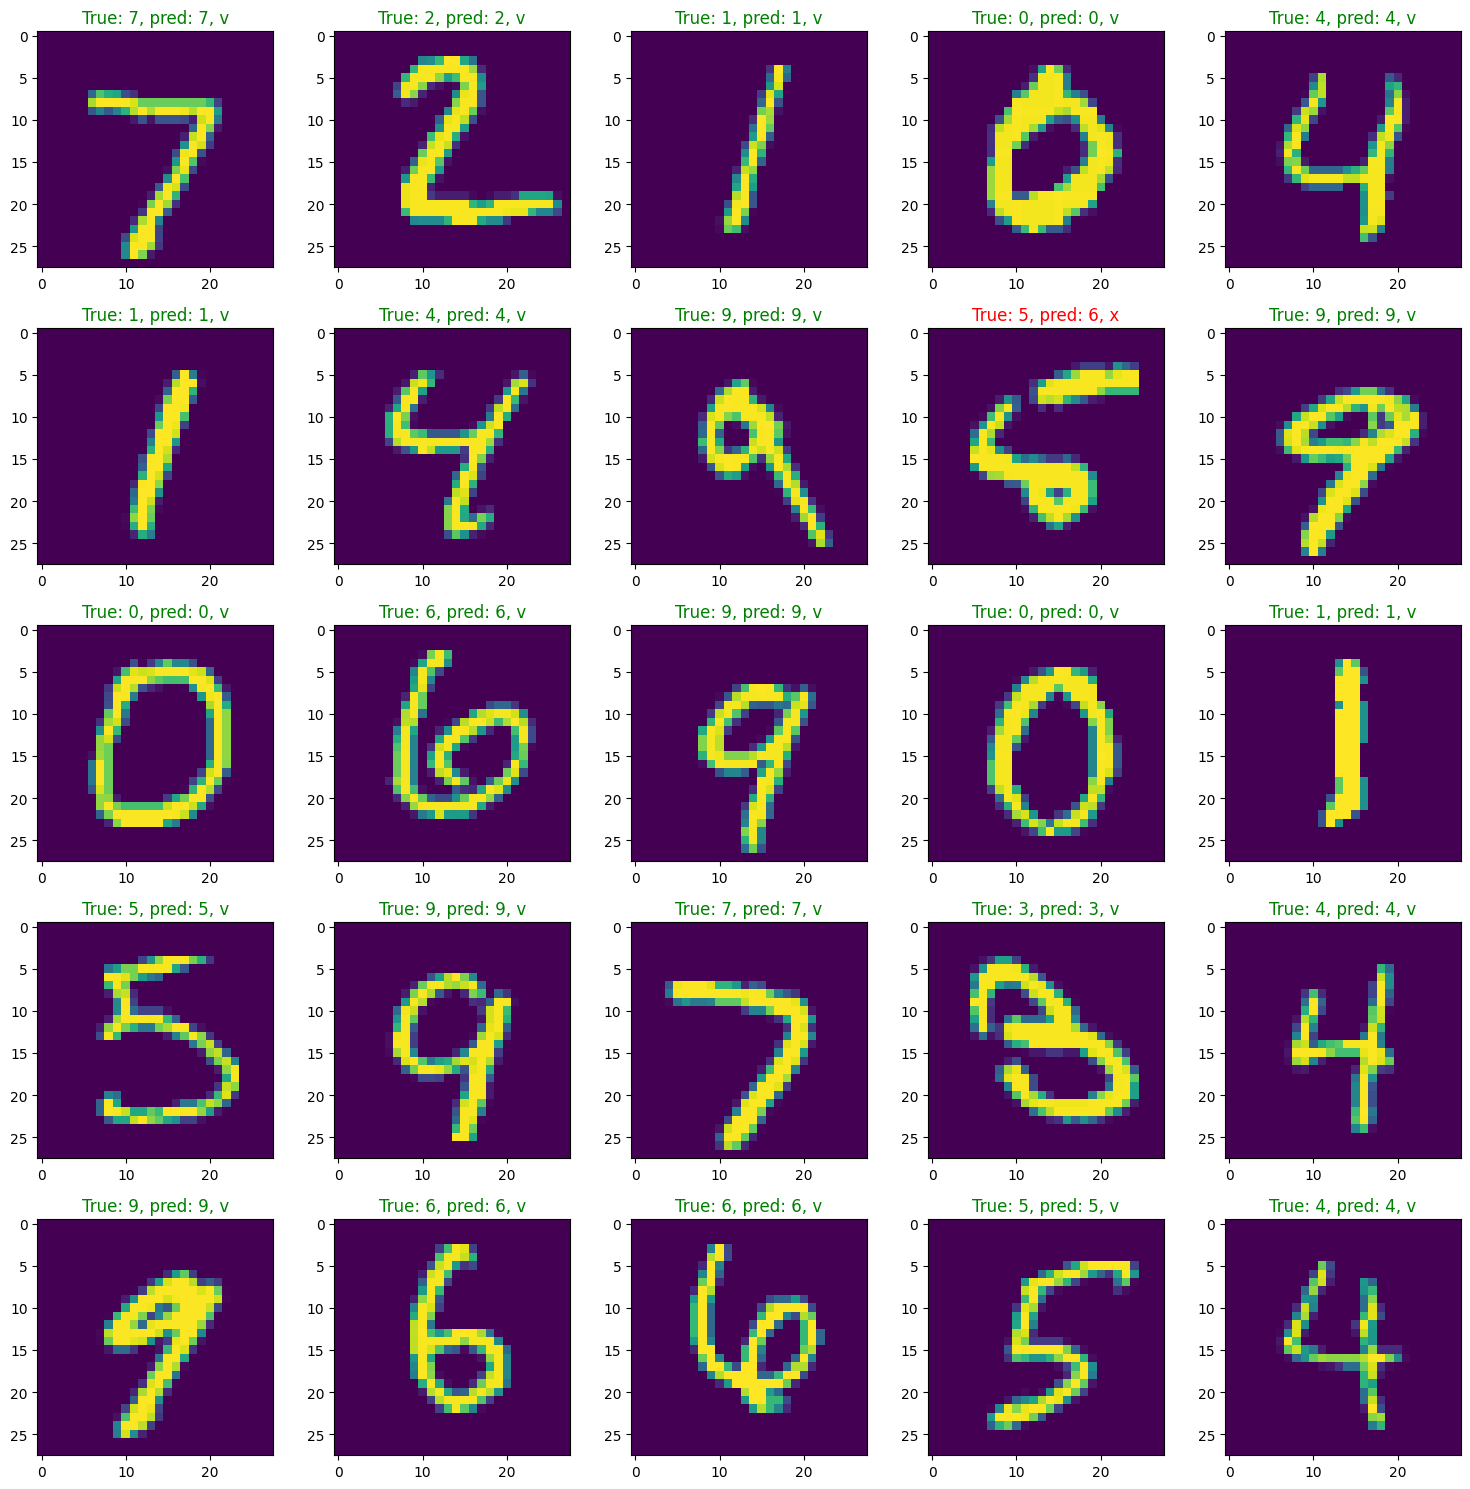

In [14]:
plt.figure(figsize=(15, 15))
for i, (digit, label) in enumerate(test_dataset):
    plt.subplot(5, 5, i + 1)
    # digit = x_test[j]
    y_pred = model(digit.reshape(1, 1, 28, 28)).argmax()
    # label = y_test[j].item()
    plt.imshow(digit.reshape(28, 28, 1))
    if int(label) == y_pred:
        plt.title(f"True: {int(label)}, pred: {y_pred}, v", color="g")
    else:
        plt.title(f"True: {int(label)}, pred: {y_pred}, x", color="r")
    if i >= 24:
        break
plt.tight_layout()